<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

To Download any pandas dataframe to exel, follow this code:
Here `world_industry_values` is python variable of pd.DataFrame type

```python
world_industry_values.to_excel('filename.xlsx')
```

In [1]:
%%time

## Installation of external files
!wget -q https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

## Installation of external python libraries
!pip install -q pyxlsb

CPU times: user 422 ms, sys: 100 ms, total: 522 ms
Wall time: 45.6 s


In [2]:
%%time

import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
from pyxlsb import open_workbook as open_xlsb
from glob import glob

CPU times: user 1.33 s, sys: 180 ms, total: 1.51 s
Wall time: 1.92 s


## SEA

In [3]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 16.5 s, sys: 231 ms, total: 16.7 s
Wall time: 27.4 s


In [128]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [129]:
year_range = list(range(2000,2015))

## Convert to USD $

In [130]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [131]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')

## Add employee hours for china which NA -> H_EMPE_CHN = EMP*2315.5
SEA.loc[((SEA['country']=='CHN') & (SEA['variable']=='H_EMPE')), 'value'] = SEA.loc[((SEA['country']=='CHN') & (SEA['variable']=='EMP')), 'value'].values*2315.5*3.5/10e3

SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [132]:
SEA.loc[(SEA['country']=='CHN') & (SEA['variable']=='H_EMPE')]

,country,variable,code,year,value
6664,CHN,H_EMPE,A01,2000,215521.045028
6665,CHN,H_EMPE,A02,2000,24562.000261
6666,CHN,H_EMPE,A03,2000,26182.090082
6667,CHN,H_EMPE,B,2000,10782.991515
6668,CHN,H_EMPE,C10-C12,2000,9433.614440
...,...,...,...,...,...
546107,CHN,H_EMPE,P85,2014,36962.375589
546108,CHN,H_EMPE,Q,2014,20757.032194
546109,CHN,H_EMPE,R_S,2014,61811.304389
546110,CHN,H_EMPE,T,2014,0.000000


In [133]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

qualitative_cols = ['EMP','EMPE','H_EMPE','GO_PI','II_PI','VA_PI','GO_QI','II_QI','VA_QI']

dfx1 = SEA_USD.loc[SEA_USD['variable'].isin(qualitative_cols)].copy()
dfx2 = SEA_USD.loc[~SEA_USD['variable'].isin(qualitative_cols)].copy()

dfx2['value'] = dfx2['value']*dfx2['value_y']

SEA_USD = pd.concat([dfx1,dfx2])

SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').sort_values(by=['country', 'variable','code']).reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [134]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [135]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
17413,HUN,GO_QI,R_S,52.504299,60.388793,69.959862,71.519623,76.245433,84.033059,88.426149,92.280142,101.526368,99.848921,100.00,102.352633,101.443026,110.034791,120.692449
26673,MEX,LAB,C27,12172.659387,12920.898740,12929.888521,12931.356938,15154.975866,17056.703471,19610.768299,20903.721417,22417.690418,20606.931241,23136.39,23178.989464,27411.492840,28192.924896,31769.941423
9406,DEU,H_EMPE,T,431.277460,432.552000,439.179120,461.020560,454.056980,462.236190,461.378250,496.651120,489.847680,487.897450,456.00,463.897920,463.047200,498.476520,519.026420
22067,JPN,II_QI,B,63.709657,55.888330,54.690530,50.357644,56.301006,67.050971,69.005959,69.765301,98.492528,83.243408,100.00,92.415689,86.800978,85.899877,87.728032


## Industry PPP in Adjusted USD $



In [136]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
148,C19,GO,5.028701e+07,6.063420e+07,7.002655e+07,8.323847e+07,1.155436e+08,2.276655e+08,3.744445e+08,4.360218e+08,7.268998e+08,5.713656e+08,6.489072e+08,8.902547e+08,9.725720e+08,1.033989e+09,1.093332e+09
180,C21,GO,3.052609e+07,3.462302e+07,3.661852e+07,3.465124e+07,3.720878e+07,4.571959e+07,5.597867e+07,6.781750e+07,1.128354e+08,1.207054e+08,1.359535e+08,1.640496e+08,1.847343e+08,2.032500e+08,2.335124e+08
228,C24,GO,6.468878e+07,8.087769e+07,8.737576e+07,9.398850e+07,1.421062e+08,1.867525e+08,2.158007e+08,2.606762e+08,3.981360e+08,3.373388e+08,3.766846e+08,4.787078e+08,4.777959e+08,5.081834e+08,5.530638e+08
852,R_S,GO,6.603591e+07,7.312042e+07,8.253058e+07,9.159363e+07,1.019314e+08,1.175773e+08,1.438060e+08,1.674646e+08,2.029172e+08,2.387695e+08,2.985511e+08,3.443515e+08,3.875778e+08,4.516868e+08,5.355893e+08
708,M69_M70,GO,1.412734e+07,1.701872e+07,2.022220e+07,2.321901e+07,2.722888e+07,3.361789e+07,4.418188e+07,5.400881e+07,7.108606e+07,8.331629e+07,1.044627e+08,1.256962e+08,1.474362e+08,1.737302e+08,2.067267e+08


## Industry Total in Current Dollars

In [137]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
324,C30,GO,4.252458e+05,4.437103e+05,4.522351e+05,4.953466e+05,5.463972e+05,6.126742e+05,6.839720e+05,8.260728e+05,9.168611e+05,8.808356e+05,9.789932e+05,1.099602e+06,1.162483e+06,1.232618e+06,1.300536e+06
820,P85,GO,1.172164e+06,1.177501e+06,1.271582e+06,1.462701e+06,1.635477e+06,1.752625e+06,1.886014e+06,2.153366e+06,2.396831e+06,2.387799e+06,2.546968e+06,2.831233e+06,2.862960e+06,2.987657e+06,3.097177e+06
676,K66,GO,4.955141e+05,4.501753e+05,4.396539e+05,4.967073e+05,5.740165e+05,6.279980e+05,7.340503e+05,8.521218e+05,7.879291e+05,7.205589e+05,7.409197e+05,7.553241e+05,7.509374e+05,7.939565e+05,8.423413e+05
484,H49,GO,1.283619e+06,1.275094e+06,1.335785e+06,1.515459e+06,1.736292e+06,1.916254e+06,2.100036e+06,2.379499e+06,2.660739e+06,2.392736e+06,2.677105e+06,3.011597e+06,3.059951e+06,3.147885e+06,3.253021e+06
884,U,GO,5.882929e+01,6.153780e+01,6.386517e+01,6.236825e+01,7.640644e+01,1.133787e+02,1.590187e+02,5.231311e+01,4.834424e+01,4.076543e+01,4.407672e+01,4.692423e+01,4.551557e+01,4.880736e+01,4.868986e+01


## PPP Ratio

In [138]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
203,C22,K,0.012559,0.010859,0.010175,0.012524,0.009483,0.009040,0.007318,0.007099,0.005976,0.005380,0.004985,0.004878,0.004570,0.004340,0.003958
857,R_S,II_PI,1.381918,1.333828,1.294411,1.252800,1.214026,1.172085,1.133090,1.095695,1.050419,1.023136,1.000000,0.975015,0.947024,0.919688,0.898285
381,D35,VA,0.022413,0.018914,0.016302,0.015219,0.014216,0.013550,0.013010,0.012760,0.012187,0.010324,0.009819,0.008324,0.007667,0.007201,0.005961
194,C22,EMP,1.208661,1.205655,1.215953,1.256434,1.166104,1.126606,1.087989,1.054757,1.004911,1.024789,1.000000,0.954623,0.948568,0.917129,0.924637
2,A01,EMP,2.036645,1.966644,1.891135,1.789416,1.637079,1.582330,1.506427,1.326780,1.171146,1.107390,1.000000,0.912620,0.849765,0.798269,0.768627


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [139]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [140]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [141]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value'].values/PPP_exchange['v_gdp'].values

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [142]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

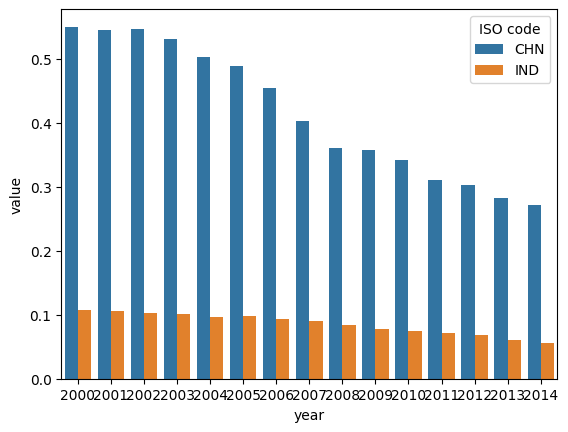

In [143]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [144]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:00<00:00, 730.26 country/s]


CPU times: user 2.17 s, sys: 25.2 ms, total: 2.2 s
Wall time: 2.2 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,9739.77,10285.682219
1,1,AUS,CAP,A02,2000,582.69,615.349661
2,2,AUS,CAP,A03,2000,869.31,918.034657
3,3,AUS,CAP,B,2000,28250.15,29833.565426
4,4,AUS,CAP,C10-C12,2000,6401.86,6760.683011


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

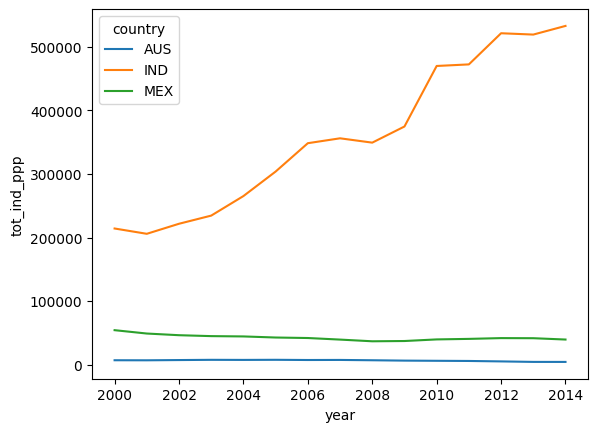

In [145]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [146]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,3.508316e+06
1,A01,2001,3.605992e+06
2,A01,2002,3.598810e+06
3,A01,2003,3.736123e+06
4,A01,2004,4.060107e+06


In [147]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,0.364607
1,A01,2001,0.354486
2,A01,2002,0.359874
3,A01,2003,0.394123
4,A01,2004,0.420667


In [148]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [149]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:00<00:00, 724.62 country/s]


CPU times: user 943 ms, sys: 16.5 ms, total: 960 ms
Wall time: 958 ms


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,0.364607,AUS,0.385043
1,A02,2000,0.389933,AUS,0.411789
2,A03,2000,0.353583,AUS,0.373401
3,B,2000,0.432509,AUS,0.456751
4,C10-C12,2000,0.516493,AUS,0.545442


### Country Industry PPP

In [150]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1).copy()
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
1572,LVA,C10-C12,2000,941.300,2.004356,1886.699931
4738,TWN,H53,2001,31898.000,0.047732,1522.561376
26284,SWE,C30,2010,37924.000,0.081224,3080.333780
29495,DEU,J62_J63,2012,103258.000,1.116514,115288.953681
33546,TUR,A03,2013,2806.949,0.562962,1580.206842


### World Industry Value

In [151]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
318,C31_C32,2003,22321.164887,5.791296e+07
145,C19,2010,2366.279871,6.489072e+08
257,C27,2002,12460.933824,1.070902e+08


In [152]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 237.00 country/s]


CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 202 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,49709.210,0.385043,19140.186311,476322.874428,2.818576e+08
1,AUS,A02,2000,2586.232,0.411789,1064.981635,49738.096661,2.897634e+07
2,AUS,A03,2000,2597.053,0.373401,969.741863,38391.775782,3.470360e+07
3,AUS,B,2000,58406.047,0.456751,26677.002857,22735.271215,2.062574e+08
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,48013.482740,4.026327e+08


### Calculate homogeneous Labour

In [184]:
world_industry_values['hom_labour'] = world_industry_values['country_ind_ppp'].values*world_industry_values['H_EMPE'].values/world_industry_values['GO'].values
world_industry_values.head()

,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
0,AUS,A01,2000,49709.210,0.385043,19140.186311,476322.874428,2.818576e+08,32.345794
1,AUS,A02,2000,2586.232,0.411789,1064.981635,49738.096661,2.897634e+07,1.828049
2,AUS,A03,2000,2597.053,0.373401,969.741863,38391.775782,3.470360e+07,1.072803
3,AUS,B,2000,58406.047,0.456751,26677.002857,22735.271215,2.062574e+08,2.940543
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,48013.482740,4.026327e+08,3.816333


In [154]:
# world_industry_values.to_excel('world_industry_values.xlsx')

### Plotting Homogeneous Labour in $

<Axes: xlabel='year', ylabel='hom_labour'>

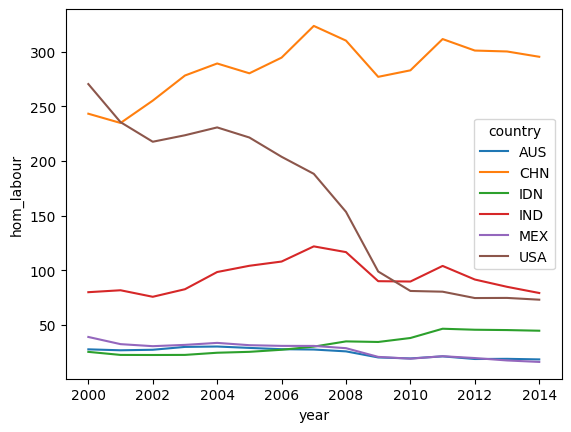

In [155]:
countries = ['IND','AUS', 'IDN', "MEX", "CHN", "USA"]
data_filter = world_industry_values.loc[(world_industry_values['country'].isin(countries)) & (world_industry_values['code']=='F')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

In [156]:
world_industry_values.describe()

,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
count,3.612000e+04,36120.000000,3.612000e+04,36120.000000,3.612000e+04,36120.000000
mean,5.619546e+06,0.685653,3.922423e+04,42011.807785,2.416405e+08,9.012194
std,5.325138e+07,0.527020,1.351723e+05,69394.334057,3.378267e+08,38.165780
min,0.000000e+00,0.000131,0.000000e+00,0.047000,5.333060e+02,0.000000
25%,1.330175e+03,0.110109,1.040668e+03,6910.142341,4.553640e+07,0.157822
50%,1.417800e+04,0.707232,5.738215e+03,18838.857782,1.357937e+08,0.919925
75%,9.733963e+04,1.057976,2.497810e+04,38218.484864,3.130893e+08,4.565799
max,3.027433e+09,3.629009,3.550996e+06,476322.874428,3.359589e+09,1305.959545


## International Market Value (MV)

MEV: Monetary Expression of Value

Unit: Price per Hour


In [157]:
SEA_USD_GO_sum

,year,value
0,2000,5.594738e+07
1,2001,5.536669e+07
2,2002,5.758435e+07
3,2003,6.501111e+07
4,2004,7.369079e+07
5,2005,8.042558e+07
6,2006,8.750179e+07
7,2007,9.929350e+07
8,2008,1.097278e+08
9,2009,1.012481e+08


In [158]:
SEA_USD_melt = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA_USD_GO_sum = SEA_USD_melt[['variable', 'value','year']][SEA_USD_melt['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()
SEA_HEMPE_sum = SEA[['variable', 'value','year']][SEA['variable']=='H_EMPE'].groupby('year').sum().drop('variable', axis=1).reset_index()

MEV = SEA_HEMPE_sum.copy().drop(['value'],axis=1)
MEV['MEV'] = SEA_USD_GO_sum['value']/SEA_HEMPE_sum['value']
MEV

,year,MEV
0,2000,26.003159
1,2001,25.547910
2,2002,26.362444
3,2003,29.469935
4,2004,32.776008
5,2005,35.377228
6,2006,37.897832
7,2007,42.268038
8,2008,46.400834
9,2009,43.069895


In [159]:
SEA_USD[SEA_USD['variable'].isin(['K','GO']) & SEA_USD['country'].isin(['AUS','IND','IDN']) & SEA_USD['code'].isin(['A01'])]

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
224,AUS,GO,A01,28947.959607,30957.684782,25292.346147,34889.990730,39645.927147,42012.510005,36429.086769,46225.675125,50077.341148,45742.080250,59637.655072,69566.630072,71514.739400,71459.259903,70292.034587
616,AUS,K,A01,39799.823577,36621.912053,39886.941034,51153.411795,62475.631242,69397.728989,74810.750515,89284.205980,95409.814050,89407.729743,105799.862882,121320.090125,125052.330802,117797.242582,112960.598377
18144,IDN,GO,A01,26971.930614,25978.475942,32278.221116,37957.120563,38814.652384,39611.879177,48107.168776,58850.741114,72528.226851,78402.845333,101622.948793,116266.943957,117716.880941,117162.620089,112492.713475
18536,IDN,K,A01,16485.304380,15055.093134,17338.851907,20624.442909,22571.328982,24128.696928,30555.346030,35150.640028,41541.671734,49670.246555,64298.781250,73679.169033,75924.637625,73993.512164,73186.723423
19040,IND,GO,A01,119836.589230,124203.712177,118370.122574,139227.773247,148234.818901,171203.461777,187717.798071,234165.135845,252618.261511,259166.931408,330669.957272,366814.957198,356133.418999,369830.454361,369345.847310
19432,IND,K,A01,144783.369345,150529.383671,155776.699764,177687.930507,204865.721118,225550.763288,241886.573458,294734.657913,319021.854878,316632.345067,373975.773299,418691.262178,432533.549308,466389.238891,474219.622470


In [160]:
SEA_USD_GO = SEA_USD_melt[SEA_USD_melt['variable']=='GO'].reset_index(drop=True)

SEA_USD_K = SEA_USD_melt[SEA_USD_melt['variable']=='K'].reset_index(drop=True)
SEA_USD_K.head()

,country,variable,code,year,value
0,AUS,K,A01,2000,39799.823577
1,AUS,K,A02,2000,1507.755523
2,AUS,K,A03,2000,2689.243546
3,AUS,K,B,2000,84688.831742
4,AUS,K,C10-C12,2000,12159.831139


### Calculate market price

In [161]:
WIV_x = world_industry_values[['country', 'code', 'year', 'hom_labour']].copy()
WIV_x

,country,code,year,hom_labour
0,AUS,A01,2000,32.345794
1,AUS,A02,2000,1.828049
2,AUS,A03,2000,1.072803
3,AUS,B,2000,2.940543
4,AUS,C10-C12,2000,3.816333
...,...,...,...,...
36115,USA,P85,2014,65.661245
36116,USA,Q,2014,652.998498
36117,USA,R_S,2014,173.444116
36118,USA,T,2014,90.079776


In [183]:
SEA_USD_K

,country,variable,code,year,value
0,AUS,K,A01,2000,3.979982e+04
1,AUS,K,A02,2000,1.507756e+03
2,AUS,K,A03,2000,2.689244e+03
3,AUS,K,B,2000,8.468883e+04
4,AUS,K,C10-C12,2000,1.215983e+04
...,...,...,...,...,...
36115,USA,K,P85,2014,5.577310e+05
36116,USA,K,Q,2014,1.428125e+06
36117,USA,K,R_S,2014,7.678859e+05
36118,USA,K,T,2014,2.009928e+04


In [162]:
MVs=[]
for year, dfx in tqdm(WIV_x.groupby('year'), unit=' Year'):
    dfx['MEVLH'] = MEV.loc[MEV['year']==year,'MEV'].iloc[0]*dfx['hom_labour']
    MVs.append(dfx)

MV_data = pd.concat(MVs)
MV_data['K'] = SEA_USD_K['value']
MV_data['GO'] = SEA_USD_GO['value']
MV_data['MP'] = MV_data['K']+MV_data['GO']
MV_data['MV'] = MV_data['MEVLH']+MV_data['K']
MV_data['diff'] = MV_data['MP']-MV_data['MV']
MV_data.head(5)

100%|██████████| 15/15 [00:00<00:00, 890.61 Year/s]


,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
0,AUS,A01,2000,32.345794,841.092813,39799.823577,28947.959607,68747.783184,40640.916390,28106.866794
1,AUS,A02,2000,1.828049,47.535045,1507.755523,1506.081860,3013.837383,1555.290567,1458.546816
2,AUS,A03,2000,1.072803,27.896256,2689.243546,1512.383426,4201.626972,2717.139802,1484.487171
3,AUS,B,2000,2.940543,76.463407,84688.831742,34012.527846,118701.359588,84765.295149,33936.064440
4,AUS,C10-C12,2000,3.816333,99.236709,12159.831139,34168.387512,46328.218651,12259.067848,34069.150803


<Axes: xlabel='year', ylabel='diff'>

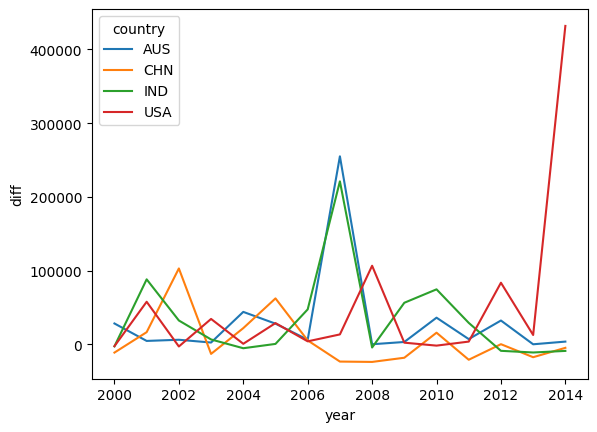

In [163]:
countries = ['IND','USA','AUS','CHN']
data_filter = MV_data.loc[(MV_data['country'].isin(countries)) & (MV_data['code']=='A01')].copy()
sns.lineplot(data=data_filter, x='year', y='diff', hue='country')

In [164]:
MV_data['diff'].describe()

,diff
count,3.612000e+04
mean,3.887301e+04
std,1.320267e+05
min,-3.670627e+04
25%,7.956921e+02
50%,5.710059e+03
75%,2.604961e+04
max,3.406087e+06


## World Input Output Analysis

### Exports

In [165]:
def extract_exports(df):
    columns = df.iloc[3,4:] +"_"+ df.iloc[4,4:]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_exp = df.iloc[5:-8, 4:].astype(float).copy().reset_index(drop=True)
    df_exp.columns=columns.values
    df_exp['supply'] = rows.values

    return df_exp

def filter_exports(df_exp):
    new_cols = []
    for col in df_exp.columns[:-2]:
        country, ind = col.split("_")  ## Add all outside of current country
        new_cols = [c for c in df_exp.columns[:-2] if country not in c]

    df_exp_filtered = df_exp[new_cols].copy()
    df_exp_filtered['supply'] = df_exp['supply']

    return df_exp_filtered

def calculate_exports(df_exp_filtered, df):

    exports = []

    for supply, dfx in df_exp_filtered.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        country,ind = supply.split("_")
        ind = ind.replace("_r","_c")
        sum_df = dfx.loc[:,(~dfx.columns.str.contains(country))]
        sum = sum_df.values.sum()

        exports.append([supply,sum])

    export_df = pd.DataFrame(exports, columns=['supply', 'exports'])


    output_GO_sum = df.iloc[5:-8,[2,3,-1]].copy()
    output_GO_sum.columns = ['country', 'code', 'GO']
    output_GO_sum['supply'] = output_GO_sum['country']+"_"+output_GO_sum['code']
    output_GO_sum.loc[output_GO_sum['GO']==0,'GO'] = float('nan')
    output_GO_sum = output_GO_sum[['supply', 'GO']].reset_index(drop=True)

    export_df_GO = pd.merge(
        left= export_df,
        right= output_GO_sum,
        on = 'supply',
        how='inner'
    )
    export_df_GO['export_total'] = export_df_GO['exports'].values / export_df_GO['GO'].values

    return export_df_GO

### Imports

In [166]:
def extract_imports(df):
    columns = df.iloc[3,4:-1] +"_"+ df.iloc[4,4:-1]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_Imp = df.iloc[5:-8, 4:-1].astype(float).copy().transpose().reset_index(drop=True)
    df_Imp.columns=rows.values
    df_Imp['supply'] = columns.values

    return df_Imp


def calculate_imports(df_Imp):
    Imports = []

    for supply, dfx in df_Imp.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        country,code = supply.split('_')
        new_supply = supply.replace("_c","_r")
        new_cols = [c for c in dfx.columns if c!=new_supply]

        sum_df = dfx.loc[:,new_cols]
        sum = sum_df.values.sum()

        ## Country filter
        col_country = [c for c in dfx.columns if country not in c]
        sum2 = dfx.loc[:,col_country].values.sum()

        Imports.append([supply,sum, sum2])

    import_df = pd.DataFrame(Imports, columns=['supply', 'imports_industry', 'imports_country'])
    return import_df

def get_total_imports(df,import_df):
    output_GO_sum = df.iloc[[3,4,-1],4:-1].transpose().copy()
    output_GO_sum.columns = ['country', 'code', 'GO']
    output_GO_sum['supply'] = output_GO_sum['country']+"_"+output_GO_sum['code']
    output_GO_sum.loc[output_GO_sum['GO']==0,'GO'] = float('nan')
    output_GO_sum = output_GO_sum[['supply', 'GO']].reset_index(drop=True)

    import_df_GO = pd.merge(
        left= import_df,
        right= output_GO_sum,
        on = 'supply',
        how='inner'
    )
    import_df_GO['import_tot_ind'] = import_df_GO['imports_industry'].values / import_df_GO['GO'].values
    import_df_GO['import_tot_country'] = import_df_GO['imports_country'].values / import_df_GO['GO'].values

    return import_df_GO

### Calculate exports and imports for years

In [167]:
%%time

with ZipFile("wiot.zip", 'r') as zObject:
    zObject.extractall()

CPU times: user 6.32 s, sys: 1.97 s, total: 8.29 s
Wall time: 12.8 s


In [168]:
IO_files = glob('WIOT*_Nov16_ROW.xlsb')
print(f"Total Input Output files: {len(IO_files)} found")

Total Input Output files: 15 found


In [169]:
df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb', nrows=10)
df.head()

,Intercountry Input-Output Table,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2679,Unnamed: 2680,Unnamed: 2681,Unnamed: 2682,Unnamed: 2683,Unnamed: 2684,Unnamed: 2685,Unnamed: 2686,Unnamed: 2687,Unnamed: 2688
0,"43 countries, in current prices",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(industry-by-industry),NaN,NaN,NaN,A01,A02,A03,B,C10-C12,C13-C15,...,CONS_np,CONS_g,GFCF,INVEN,CONS_h,CONS_np,CONS_g,GFCF,INVEN,GO
2,(millions of US$),NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Total output
3,NaN,NaN,NaN,NaN,AUS,AUS,AUS,AUS,AUS,AUS,...,USA,USA,USA,USA,ROW,ROW,ROW,ROW,ROW,TOT
4,NaN,NaN,NaN,NaN,c1,c2,c3,c4,c5,c6,...,c58,c59,c60,c61,c57,c58,c59,c60,c61,c62


In [170]:
df_industry = pd.DataFrame(list(zip(df.iloc[4, 4:4+56], df.iloc[1, 4:4+56])), columns = ['c_index', 'code'])
df_industry['r_index'] = df_industry['c_index'].str.replace("c",'r')
df_industry.head()

,c_index,code,r_index
0,c1,A01,r1
1,c2,A02,r2
2,c3,A03,r3
3,c4,B,r4
4,c5,C10-C12,r5


In [171]:
# %%time

# import_dfs = []
# export_dfs = []


# for file in tqdm(IO_files):
#     year = pd.ExcelFile(file).sheet_names[0]
#     df = pd.read_excel(file, engine='pyxlsb')

#     ## Calculate exports:
#     df_exp = extract_exports(df)
#     df_exp_filtered = filter_exports(df_exp)
#     export_df = calculate_exports(df_exp_filtered,df)
#     export_df['year'] = year

#     ## Calculate imports:
#     df_Imp = extract_imports(df)
#     import_df = calculate_imports(df_Imp)
#     total_imports = get_total_imports(df,import_df)
#     total_imports['year'] = year

#     ## Add to list
#     export_dfs.append(export_df)
#     import_dfs.append(total_imports)


# imports_all = pd.concat(import_dfs)
# exports_all = pd.concat(export_dfs)

# exports_all.to_excel('exports.xlsx', index=False)
# imports_all.to_excel('imports.xlsx', index=False)

In [172]:
%%time
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/exports.xlsx -O exports.xlsx
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/imports.xlsx -O imports.xlsx

exports_all = pd.read_excel('exports.xlsx').sort_values(by='year')
exports_all[['country', 'r_index']] = exports_all['supply'].str.split('_').to_list()
exports_all = exports_all.drop('supply', axis=1)

## Merge industry to the imports
exports_all = pd.merge(
    left=exports_all,
    right=df_industry,
    how='inner',
    on='r_index'
)

exports_all = exports_all.drop(['c_index', 'r_index'],axis=1)

imports_all = pd.read_excel('imports.xlsx').sort_values(by='year')
imports_all[['country', 'c_index']] = imports_all['supply'].str.split('_').to_list()
imports_all = imports_all.drop('supply', axis=1)

## Merge industry to the imports
imports_all = pd.merge(
    left=imports_all,
    right=df_industry,
    how='inner',
    on='c_index'
)

imports_all = imports_all.drop(['c_index', 'r_index'],axis=1)

CPU times: user 10.9 s, sys: 57 ms, total: 10.9 s
Wall time: 12.1 s


In [173]:
exports_all

,exports,GO,export_total,year,country,code
0,2378.567872,107642.000000,0.022097,2000,USA,C18
1,252.519645,1818.568400,0.138856,2000,FIN,C18
2,21.767674,68.110958,0.319591,2000,EST,C18
3,18.561641,11557.930400,0.001606,2000,FRA,C18
4,233.555196,1885.610856,0.123862,2000,DNK,C18
...,...,...,...,...,...,...
36955,270.130656,475.928817,0.567586,2014,DNK,C30
36956,5351.804736,20814.193874,0.257123,2014,ESP,C30
36957,43129.075080,78038.908874,0.552661,2014,FRA,C30
36958,22510.083265,50259.082159,0.447881,2014,GBR,C30


In [174]:
exp_imp_df = pd.merge(
    left=imports_all,
    right=exports_all,
    on = ['code', 'country', 'year'],
    how='inner',
    suffixes = ('', "_y")
)

exp_imp_df.drop(['GO_y'],axis=1,inplace=True)

exp_imp_df.head(5)

,imports_industry,imports_country,GO,import_tot_ind,import_tot_country,year,country,code,exports,export_total
0,58922.145933,5682.712898,107642.000000,0.547390,0.052793,2000,USA,C18,2378.567872,0.022097
1,977.467780,122.972424,1818.568400,0.537493,0.067620,2000,FIN,C18,252.519645,0.138856
2,39.482440,23.457050,68.110958,0.579678,0.344395,2000,EST,C18,21.767674,0.319591
3,5794.942767,1430.285569,11557.930400,0.501382,0.123749,2000,FRA,C18,18.561641,0.001606
4,840.011234,342.490180,1885.610856,0.445485,0.181634,2000,DNK,C18,233.555196,0.123862


### Merge with DIFF

- MV['diff'] * exports_total on same industry, country and year
-

In [175]:
MV_data.sample(5)

,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
23573,LVA,R_S,2000,0.642172,16.698509,9617.606285,16293.261559,25910.867844,9634.304794,16276.563050
28818,PRT,H53,2004,0.615778,20.182734,4287.539031,2160.025794,6447.564825,4307.721765,2139.843060
27216,NOR,A01,2006,1.762243,66.785185,1153.537872,1133.366400,2286.904272,1220.323057,1066.581215
20760,JPN,K64,2010,19.678150,925.514723,1007.487616,1636.719376,2644.206992,1933.002340,711.204653
32127,SVN,J62_J63,2003,0.197281,5.813858,2673.465300,11388.457500,14061.922800,2679.279158,11382.643642


In [176]:
imports_diff = pd.merge(
    left = exp_imp_df,
    right = MV_data,
    on = ['country', 'code', 'year'],
    how='inner',
    suffixes = ("", "_y")
)
exp_imp_df['unequal_exchange'] = (exp_imp_df['export_total'] - exp_imp_df['import_tot_country'])*imports_diff['diff']
# exp_imp_df = exp_imp_df.drop(['level_0', "GO_y"],axis=1)

## Rearrange Columns
index_cols = ['year', 'country', 'code']
val_cols = [c for c in exp_imp_df.columns if c not in index_cols]
index_cols.extend(val_cols)
exp_imp_df = exp_imp_df[index_cols].reset_index(drop=True)

exp_imp_df.sample(5)

,year,country,code,imports_industry,imports_country,GO,import_tot_ind,import_tot_country,exports,export_total,unequal_exchange
25619,2012,BGR,G47,1573.958521,302.024786,3763.815128,0.418182,0.080244,107.558881,0.028577,-3.686931
1764,2010,ESP,M73,7203.696793,564.544395,14322.862800,0.502951,0.039416,1127.826400,0.078743,-17.356527
27417,2008,JPN,G45,68752.055666,6408.020437,121774.961646,0.564583,0.052622,34.696596,0.000285,-17780.859462
22379,2013,PRT,H51,3214.347378,720.545883,4979.453331,0.645522,0.144704,2983.902670,0.599243,3156.729860
19690,2012,ROW,T,0.000000,0.000000,21108.226112,0.000000,0.000000,8914.645087,0.422330,267944.862730


In [177]:
## pivot wider
SEA_ue = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year').reset_index()
SEA_ue = SEA_ue.pivot(columns=['variable'], index=['year', 'country', 'code'], values='value').reset_index()
SEA_ue.head()

variable,year,country,code,CAP,COMP,EMP,EMPE,GO,GO_PI,GO_QI,H_EMPE,II,II_PI,II_QI,K,LAB,VA,VA_PI,VA_QI
0,2000,AUS,A01,5671.916100,3226.789086,389.305,181.466,28947.959607,91.576,83.693,394.068,16353.499771,91.576,86.254,39799.823577,6922.541406,12594.459835,91.575,80.586
1,2000,AUS,A02,339.327191,122.241996,14.654,13.000,1506.081860,91.576,102.122,28.168,1028.959377,91.576,120.261,1507.755523,137.794128,477.121901,91.575,77.057
2,2000,AUS,A03,506.239201,218.031507,17.888,11.313,1512.383426,91.576,94.004,28.191,661.384911,91.576,91.787,2689.243546,344.756402,850.997933,91.575,95.801
3,2000,AUS,B,16451.361852,3949.771645,79.366,76.637,34012.527846,36.192,68.921,180.812,13470.706544,36.192,63.288,84688.831742,4090.460033,20541.820720,36.192,73.193
4,2000,AUS,C10-C12,3728.097564,5125.503178,196.387,187.584,34168.387512,80.044,84.734,358.950,25074.236526,80.044,86.383,12159.831139,5366.052840,9094.150986,80.044,80.497


In [178]:
exp_imp_df_sea = pd.merge(
    left=exp_imp_df,
    right=SEA_ue,
    on=['year', 'country', 'code'],
    suffixes=('', '_y'),
    how='inner'
)

exp_imp_df_sea = exp_imp_df_sea.sort_values(by=['year', 'country', 'code']).reset_index(drop=True)
exp_imp_df_sea.head()

,year,country,code,imports_industry,imports_country,GO,import_tot_ind,import_tot_country,exports,export_total,...,GO_QI,H_EMPE,II,II_PI,II_QI,K,LAB,VA,VA_PI,VA_QI
0,2000,AUS,A01,10122.866846,1256.399702,28947.959651,0.349692,0.043402,4801.968409,0.165883,...,83.693,394.068,16353.499771,91.576,86.254,39799.823577,6922.541406,12594.459835,91.575,80.586
1,2000,AUS,A02,922.530634,142.886062,1506.081601,0.612537,0.094873,33.794562,0.022439,...,102.122,28.168,1028.959377,91.576,120.261,1507.755523,137.794128,477.121901,91.575,77.057
2,2000,AUS,A03,615.308755,104.858290,1512.383198,0.406847,0.069333,276.501379,0.182825,...,94.004,28.191,661.384911,91.576,91.787,2689.243546,344.756402,850.997933,91.575,95.801
3,2000,AUS,B,12153.045067,1882.274569,34012.527629,0.357311,0.055341,11070.489602,0.325483,...,68.921,180.812,13470.706544,36.192,63.288,84688.831742,4090.460033,20541.820720,36.192,73.193
4,2000,AUS,C10-C12,19890.488441,1459.414899,34168.387578,0.582131,0.042712,6591.797599,0.192921,...,84.734,358.950,25074.236526,80.044,86.383,12159.831139,5366.052840,9094.150986,80.044,80.497


<Axes: xlabel='year', ylabel='unequal_exchange'>

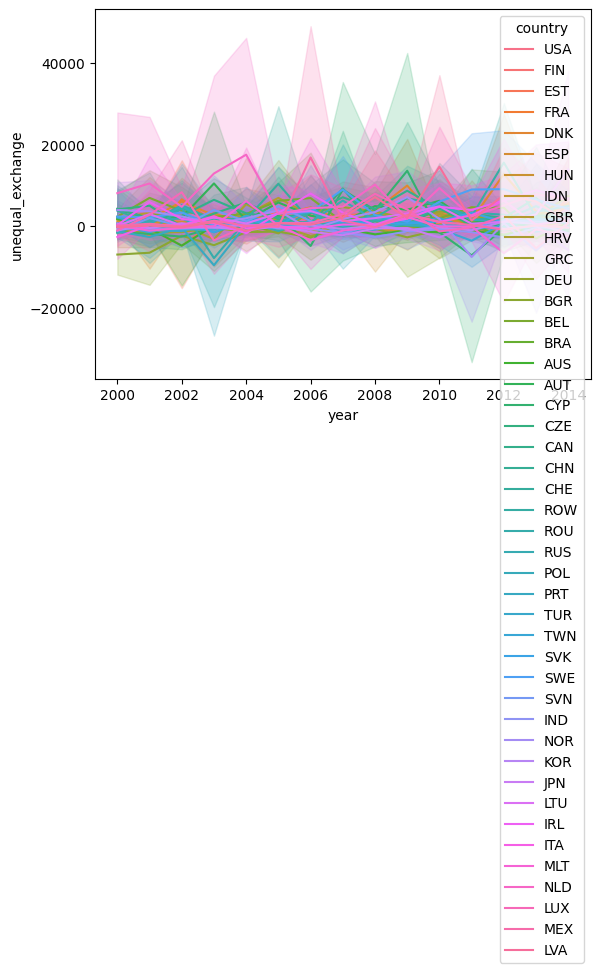

In [179]:
sns.lineplot(x='year', y='unequal_exchange', data=exp_imp_df, hue='country')